In [1]:
import os
import io
import requests

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

PROJ_PATH = '/home/reese56/w266_final/'
VOTEVIEW = os.path.join(PROJ_PATH, 'data/voteview/')
VOTEVIEW_RAW = os.path.join(VOTEVIEW, 'data/voteview/raw/')
SAVE_PATH = os.path.join(VOTEVIEW, 'gen/')

In [2]:
# import voteview congressional members dw-nominate score data
try:
    member_ideology = pd.read_csv(os.path.join(VOTEVIEW_RAW, 'raw/member_ideology.csv'))
except FileNotFoundError:
    url= 'https://voteview.com/static/data/out/members/HSall_members.csv'
    r = requests.get(url).content
    member_ideology = pd.read_csv(io.StringIO(r.decode('utf-8')))

In [3]:
# select major political parties
party_codes = member_ideology['party_code'].isin([100,200])

# select desired congressional sessions
period = member_ideology['congress'] >= 75

# select desired attributes
attributes = ['congress','chamber','state_icpsr',
            'district_code','party_code','nominate_dim1',
            'nominate_number_of_votes','nominate_number_of_errors']

# select chambers
chambers = member_ideology['chamber'].isin(['House','Senate'])

# apply selections
member_ideology = member_ideology[party_codes & period & chambers].filter(attributes)

In [4]:
# party aggregate ideology by congress 
party_ideology = (member_ideology
                  .groupby(['congress','party_code'], as_index= False)
                  .agg({'nominate_dim1':np.sum, 'chamber':'count'})
                  .rename({'chamber':'count'}, axis = 1))

In [5]:
# democrat subset
dem_sel = party_ideology[party_ideology['party_code'] == 100].drop('party_code', axis=1)
dem_sel.rename({'nominate_dim1':'dem_nom','count':'dem_count'}, axis = 1, inplace = True)

# gop subset
gop_sel = party_ideology[party_ideology['party_code'] == 200].drop('party_code', axis=1)
gop_sel.rename({'nominate_dim1':'gop_nom','count':'gop_count'}, axis = 1, inplace = True)

In [6]:
# merge party subsets
party_ideo_mu = dem_sel.merge(gop_sel, how = 'inner', on = 'congress')

# calculate mean diff ideology
party_ideo_mu['mu_diff'] = (
    (party_ideo_mu['gop_nom'] - party_ideo_mu['dem_nom'])
    /(party_ideo_mu['dem_count'] + party_ideo_mu['gop_count']))

# party mean ideology
party_ideo_mu['dem_nom'] = party_ideo_mu['dem_nom']/party_ideo_mu['dem_count']
party_ideo_mu['gop_nom'] = party_ideo_mu['gop_nom']/party_ideo_mu['gop_count']

In [8]:
# save
try:
    party_ideo_mu.to_csv(os.path.join(SAVE_PATH,'party_ideo_mu.csv'), index = False)
except FileNotFoundError:
    os.mkdir(SAVE_PATH)
    party_ideo_mu.to_csv(os.path.join(SAVE_PATH,'party_ideo_mu.csv'), index = False)

In [9]:
party_ideo_mu.head(n=3)

,congress,dem_nom,dem_count,gop_nom,gop_count,mu_diff
0,75,-0.247534,427,0.298195,113,0.258135
1,76,-0.240994,349,0.301020,205,0.263206
2,77,-0.245720,354,0.299473,201,0.265187


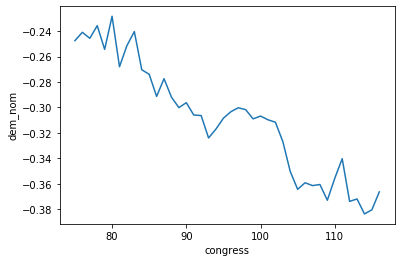

In [7]:
import seaborn as sns

# democrat mean vis
sns.lineplot(x = 'congress', y = 'dem_nom', data = party_ideo_mu);

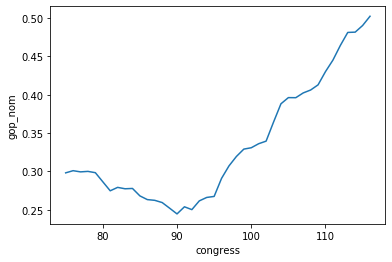

In [8]:
# gop mean vis
sns.lineplot(x = 'congress', y = 'gop_nom', data = party_ideo_mu);

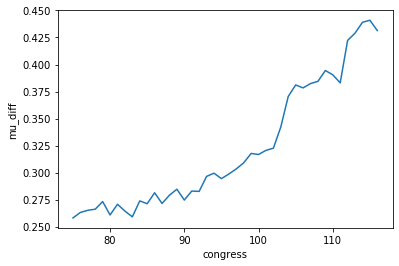

In [9]:
# party mean diff vis
sns.lineplot(x = 'congress', y = 'mu_diff', data = party_ideo_mu);